In [1]:
from GeneralUse import *
from ArrayToRTKConversion import *
from RTKToArrayConversion import * 
from ExtendedConeBeamDcc import *
from tqdm import tqdm_notebook

In [2]:
#Choose projections file and geometry file
projFile = ""
geoFile = ""

#Read the projections
proj = itk.imread(projFile)

#Read the geometry
xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
xmlreader.SetFilename(geoFile)
xmlreader.GenerateOutputInformation()
geometry = xmlreader.GetOutputObject()

In [3]:
#Convert to array for faster computation
geometryArray = RTKtoNP(geometry)
projArray = itk.GetArrayFromImage(proj)
projSpacing, projOrigin, projSize, projDirection = GetProjectionInformations(proj)
print(projSpacing, projOrigin, projSize)
#print some parameters
print(ExtractGeometricParameters(geometryArray, projSize, projSpacing))

[1.02806101 0.6        1.        ] [0. 0. 0.] [  920    32 44788]
([0.0, 48.17, 0], 30, 1536, 15.400000000000034, 0.8020833333333351, 251.45728933957625)


In [4]:
#Under sample the stack
projSub, geometrySub, projSubArray, geometrySubArray = SubsampleAcquisition(geometryArray, projArray, projSpacing, projOrigin, projSize, projDirection) # Number of sampled is 20 per rotation
projSpacing, projOrigin, projSize, projDirection = GetProjectionInformations(projSub)
print(projSpacing, projOrigin, projSize)
nproj = projSize[2]
center, nb_rotations, nb_proj_per_rotations, d, pitch, r_fov = ExtractGeometricParameters(geometrySubArray, projSize, projSpacing)
print(center, nb_rotations, nb_proj_per_rotations, d, pitch, r_fov, nproj)
#And extract the necessary other parameters
sourcePositions = GetSourcePositions(geometrySub)
rotationMatrices = GetRotationMatrices(geometrySub)
FixedSystemMatrices = GetFixedSystemMatrices(geometrySub)

[1.02806101 0.6        1.        ] [0. 0. 0.] [920  32 584]
[0.0, 47.39, 0] 30 20 15.400000000000034 0.8020833333333351 251.45728933957625 584


In [5]:
#Compute the all pairs possible in the acquisition
s0 = (nb_proj_per_rotations//2 - 1)*nb_rotations//2
rangeList=[]
s1L = [i for i in range(nproj) if i != s0]
for s1 in tqdm_notebook(s1L):
    r = CheckPairOverlapCondition(geometrySubArray, FixedSystemMatrices, projDirection, projSize, projSpacing, projOrigin, sourcePositions, s0, s1)
    if r != 0:
        rangeList.append(r)
rangeList.sort()

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


invalid value encountered in true_divide


In [6]:
#Compute the DCC
ListOfPairs = []
distances = []
k=0
for i0 in tqdm_notebook(np.arange(s0//(nb_rotations//2),nproj,nb_proj_per_rotations)):
    ListOfPairs.append([])
    distances.append([])
    for i1 in rangeList:
        if i1+i0 < 0 or i1+i0 > nproj-1:
            pass
        else:
            m0_trpz, m1_trpz, norm0, norm1, grad0, grad1 = ComputeMomentsOnCylindricalDetectorsWithSingularity(geometrySubArray, FixedSystemMatrices, projDirection, projSubArray, projSize, projSpacing, projOrigin, sourcePositions, i0, i1 + i0)
            ListOfPairs[k].append([i0,i0+i1])
            err = np.sum(np.abs(m0_trpz-m1_trpz))/len(m0_trpz)
            distances[k].append(err)
    k+=1

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


<IPython.core.display.Javascript object>


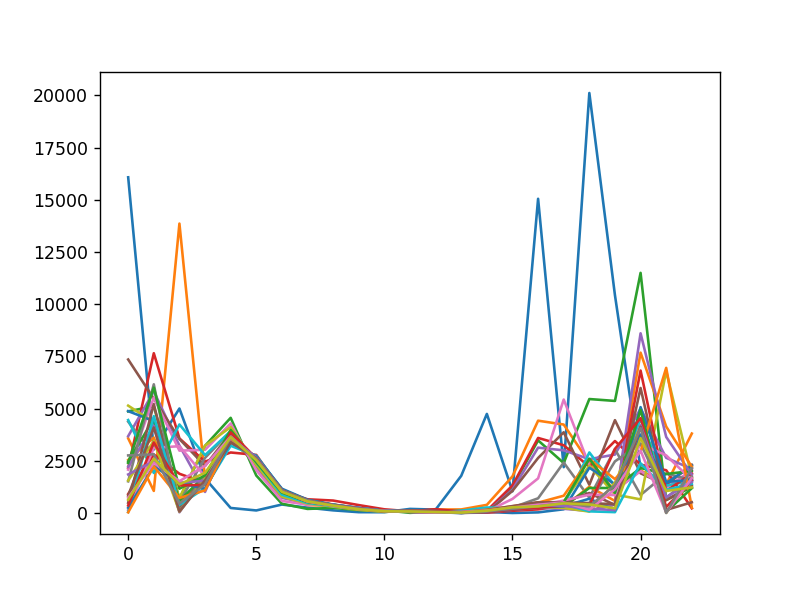

In [7]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
for i in range(len(distances)):
    plt.plot(distances[i])
plt.show()